## Semi Supervised Leanring GAN for Image Classfication/Recognize Outliers (Keras version)

In [1]:
import csv
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time

### 1. Read input from h5py
- ** Input: image dataset with shape $( m, IMSIZE, IMSIZE, 3)$ **
    - $m$: number of traing examples
    - IMSIZE: image width or highth (normally 64, 128, 256)
    - 3: color channel RGB
- $n_x$ : $n_x = IMSIZE*IMSIZE*3$: number of features of single training example, where $IMSIZE = 128$

In [4]:
f = h5py.File('data.h5','r')
#data = h5f['outside_front_1000'][:]
#X_train = h5f['wipehero_outside_front_12330'][:]
#group = f['outside_front_50']
group = f['outside_front_100']
X_train = group['X'][:]
Y_train = group['Y'][:]
f.close()
print(X_train.shape, Y_train.shape)

((100, 64, 64, 3), (100,))


#### CONSTANTS DEFINING THE MODEL ####

In [5]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

m = X_train.shape[0]                 # number of training examples
n_x = img_width * img_height *3      # num_px * num_px * 3 

print("%d trainging examples. \nEach example contain %d input features." % (m, n_x))
print("Training labels shape:" + str(Y_train.shape))
print("Image_width:"+ str(img_width) + " Image_height:" + str(img_height) + " Image_depth:" + str(img_depth))

100 trainging examples. 
Each example contain 12288 input features.
Training labels shape:(100,)
Image_width:64 Image_height:64 Image_depth:3


#### Display randomly 36 images from dataset

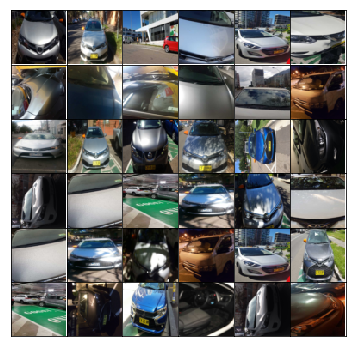

In [6]:
idx = np.random.randint(0, m, size = 36)
fig, axes = plt.subplots(6, 6, sharex = True, sharey = True, figsize = (6,6),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(X_train[ii,:,:,:], aspect ='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Preporessing data

In [7]:
print("original X_train shape:" + str(X_train.shape))
#print("original X_train:" + str(X_train))

original X_train shape:(100, 64, 64, 3)


In [9]:
# Flatten the training example data. (m: # data features, nx:# data)
#x_flatten = X_train.reshape(n_x, -1).T # The "-1" makes reshape flatten the remaining dimensions

# Scale image vectors to feature range (-1,1)
#x_train = (x_flatten.astype(np.float32) - 127.5) / 127.5
x_train = (X_train.astype(np.float32) - 127.5) / 127.5
# Standardize/Normalize image vectors to feature values (0,1).
#X_train_n = x_flatten/255.     

y_train = Y_train.reshape(-1, 1)   # reshape to (m,1)

print("Minimum value of x_train: " + str(np.min(x_train)) + "\nMaximum value of x_train: " + str(np.max(x_train)))
print("x_train shape:" + str(x_train.shape) + "\ny_train shape:" + str(y_train.shape))

Minimum value of x_train: -1.0
Maximum value of x_train: 1.0
x_train shape:(100, 64, 64, 3)
y_train shape:(100, 1)


### Support function: count elapsed time

In [10]:
# input: sec = end_time - start_time
def elapsed_time(sec):
    msg = ""
    if sec < 60:
        msg = str(sec) + "sec"
    elif sec < 60*60:
        msg = str(sec / 60) + "min"
    else:
        msg = str(sec / (60*60)) + "hour"
    print("Elapsed " + msg)

## Build SGAN
- Part1
    - Build Generator 
    - Build Discriminator
- Part2 Build GAN Model
    - Build Discriminative Model (DM) (the police)
    - Build Adversarial Model (AM) or Generator-Discriminator (the counterfeiter learning from the police).

- Part3 - Training

[keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.

In [11]:
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
#from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, RMSprop
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

from PIL import Image
import math
import argparse

Using TensorFlow backend.


### Generator
- Layer 1: Fully connected layer with $1024*4*4$ hidden units
    - input_shape: 100-dimensional vectors; output_shape: (4,4,1024); 
    - Batch Normalization: normalize Z_[l-1]; Activation: ReLU; Regularization: Dropout. 
    - Upsampling.

- Layer 2: Convolutional layer with 512 filters: 
    - input_shape (4,4,1024); output_shape (4,4, 512); 
    - activation: ReLU. 
    - Upsampling.

- Layer 3: Convolutional layer with 256 filters (output image depth = 256): 
    - input_shape (4,4, 512); output_shape (4,4,256); 
    - activation: ReLU. 
    - Do Upsampling.

- Layer 4: Convolutional layer with 128 filters (output image depth = 128): 
    - input_shape (4,4, 256); output_shape (4,4,128); 
    - activation: ReLU. 
    - Do Upsampling.

- Layer 5: Convolutional layer with 3 filters (output image depth = 3):
    - input_shape (4,4, 128); output_shape (4,4,3);
    - activation: Tanh 

In [97]:
def generator_model():
    FILTERS = 1024
    g_model = Sequential()
    
    # Layer 1: Fully connected layer
    # with input_shape (100,): 100-dimensional vectors; output_shape:(4,4,1024)
    g_model.add(Dense(FILTERS*4*4, activation="relu", input_dim=100))
    g_model.add(BatchNormalization(momentum=0.8))
    g_model.add(Reshape((4,4,FILTERS)))
    g_model.add(Dropout(0.3))   # add dropout
    g_model.add(UpSampling2D())
    # Layer 2: input_shape (4,4,1024), output_shape (4,4, 512)
    g_model.add(Conv2D(FILTERS/2, kernel_size=3, padding="same")) # filters = 1024/2=512
    g_model.add(BatchNormalization(momentum=0.8)) # BN
    g_model.add(Activation("relu"))
    g_model.add(UpSampling2D())
    # Layer 3: input_shape (4,4,512), output_shape (4,4,256)
    g_model.add(Conv2D(FILTERS/4, kernel_size=3, padding="same")) # filters = 1024/4=256
    g_model.add(BatchNormalization(momentum=0.8)) # BN
    g_model.add(Activation("relu"))
    g_model.add(UpSampling2D())
    # Layer 4: input_shape (4,4,256), output_shape (4,4,128)
    g_model.add(Conv2D(FILTERS/8, kernel_size=3, padding="same")) # filters = 1024/8=128
    g_model.add(BatchNormalization(momentum=0.8)) # BN
    g_model.add(Activation("relu"))
    g_model.add(UpSampling2D())
    # Layer 5: input_shape (4,4,128), output_shape (4,4,3)
    g_model.add(Conv2D(3, kernel_size=3, padding="same")) # filters = 3
    g_model.add(Activation("tanh"))
    
    g_model.summary()
    
    noise = Input(shape = (100,)) # This returns a tensor
    image = g_model(noise)        # model can be treat as layer, can be called on a tensor
    
    # This creates a model that includes
    # the Input layer and (1 Dense + 4 Conv) layers
    generator = Model(noise, image) # Model with input = noise, output = image
    return generator

### Discriminiator/Classfier Model
- Layer 1: Conv2D with 64 filters 
- Layer 2: Conv2D with 128 filters
- Layer 3: Conv2D with 256 filters
- Layer 4: Conv2D with 512 filters
- Flatten 
- Output Layer 1 - Binary_Dense: Fully connected layer with 1 hidden units (sigmoid)
- Output Layer 2 - Classes_Dense: Fully connected layer with (2+1) hidden units (softmax)

In [119]:
def discriminator_model(num_classes):
    image_shape = (img_width, img_height, img_depth)
    
    d_model = Sequential()
    # Layer 1: input shape: (64,64,3) output shape:(32,32,64)
    d_model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=image_shape, padding="same"))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45)) # 1st try: 0.25, 2nd try 0.45
    # Layer 2: input shape: (32,32,64) output shape:(17, 17, 128) 
    d_model.add(Conv2D(128, kernel_size=5, strides=2,padding="same")) # output shape: (16, 16, 128)
    d_model.add(ZeroPadding2D(padding=((0,1),(0,1))))                 # output shape: (17, 17, 128) 
    d_model.add(BatchNormalization(momentum=0.8))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45))
    # Layer 3: input shape: (17, 17, 128)  output shape:(9,9,256)
    d_model.add(Conv2D(256, kernel_size=5, strides=2,padding="same"))
    d_model.add(BatchNormalization(momentum=0.8))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45))
    # Layer 4: input shape: (9,9,256)  output shape:(5, 5, 512)
    d_model.add(Conv2D(512, kernel_size=5, strides=2,padding="same"))
    d_model.add(BatchNormalization(momentum=0.8))
    d_model.add(LeakyReLU(alpha=0.2))
    d_model.add(Dropout(0.45))
    
    # Flatten shape to one dimensional, transition to FC
    d_model.add(Flatten())
    d_model.summary()
    
    image = Input(shape = image_shape)
    features = d_model(image)
    
    # Creating two output layers
    # 1. 1 Fully Connected Layer with 1 hidden unit and input: features
    # sigmoid: for binary classes
    valid = Dense(1, activation ="sigmoid", name = "Binary_Dense")(features)
    # 2. 1 Fully Connected Layer with 2+1 hidden units and input: features
    # softmax: for mutiple classes
    label = Dense(num_classes+1, activation="softmax", name = "Classes_Dense")(features)
    
    # Multi-output model: input = img, outputs =[valid, label]
    # valid: main_output
    # label: auxiliary_output
    discriminator = Model(image, [valid, label])
    return discriminator

In [120]:
class SGAN():
    def __init__(self):
        
        # To keep track of loss, accuracy
        self.d_loss, self.g_loss = [], []
        self.d_binary_loss, self.d_binary_acc = [], []
        self.d_classes_loss, self.d_classes_acc = [], []
        
        # Initialization
        self.numClassess = 2               # 2 classes: normal (0), outlier (1)
        optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay=0.0)  
        # Optimizer Adam: with default value: lr = 0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
        #d_optimizer = Adam(lr=0.0002, beta_1=0.5) 
        #g_optimizer = Adam(lr=0.0004, beta_1=0.5)
        
        
        # 1. Build and compile the discriminator/classfier
        print("1.Build and compile the discriminator")
        self.discriminator = discriminator_model(self.numClassess)
        self.discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
                             loss_weights=[0.5, 0.5],  # assign a weight of 0.5 to the label(auxiliary_output) loss, weight 0.5 to valid (main_output) loss
                             optimizer=optimizer,
                             metrics=['accuracy'])
        
        # 2. Build and compile the generator
        print("2.Build and compile the generator")
        self.generator = generator_model()
        self.generator.compile(loss=['binary_crossentropy'], optimizer=optimizer)
    
    
        # 3. Combined Model: stacked generator and discriminator
        # 3.1. The generator takes noise as input and generates images
        noise = Input(shape=(100,))
        image = self.generator(noise)
        # 3.2. Only train generator in combined model, not train discriminator
        self.discriminator.trainable = False
        # 3.3. The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(image)
        # 3.4. combined model: noise => generates images => determine validity
        self.combinded_model = Model(noise, valid)
        self.combinded_model.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        

    def train(self, X_train, y_train, epochs = 500, batch_size=32, save_interval=50):
        # X_train: range from -1 to 1
        # y_train: shape (-1, 1) where -1 represent the number of examples
    
        half_batch = int(batch_size/2)
    
        # Class weights initialization:
        # To balance the difference in occurences of classes labels. 
        # 50% of labels that the discriminator trains on are 'fake'.
        # Weight = 1 / frequency
        cw1 = {0: 1, 1: 1}
        cw2 = {i: self.numClassess / float(half_batch) for i in range(self.numClassess)}
        cw2[self.numClassess] = 1 / float(half_batch)
        print"Class weights initialization: \nDiscriminator: 1.Real=%f, 2.Fake=%f \nClassifier: 1.Normal Cars=%f, 2.Outliers=%f, 3.Fake=%f" %
                (cw1[0],cw1[1], cw2[0], cw2[1], cw2[2])
        
        for epoch in range(epochs):
            #--------------------------------
            # Train Discrimator
            #--------------------------------
            # Select a random half batch of images： size = half_batch
            idx = np.random.randint(0, X_train.shape[0], half_batch) # 16 random integer in range (0,m).
            images = X_train[idx]  # X_train[idx,:,:,:] get 16 train examples
        
            # Generate a random half batch of images from noise
            noise = np.random.normal(0, 1, (half_batch, 100))
            generated_images = self.generator.predict(noise)
        
            valid = np.ones((half_batch, 1)) # all 1 vectors with shape(16,1)
            fake = np.zeros((half_batch, 1)) # all 0 vectors with shape(16,1)
        
            # Convert labels to categorical one-hot encoding： one_hot_labels
            labels = to_categorical(y_train[idx], num_classes = self.numClassess+1)
            fake_labels = to_categorical(np.full((half_batch, 1), self.numClassess), num_classes = self.numClassess+1)
        
            # Train the discriminator/classfier by calculating loss value of D. 
            d_loss_real = self.discriminator.train_on_batch(images, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(generated_images, [fake, fake_labels], class_weight=[cw1, cw2])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
        
            #------------------------------------------------
            # Train Generator by fixing Discriminator
            #------------------------------------------------
            noise = np.random.normal(0, 1, (batch_size, 100))   # Sample noise with shape (batch_size, 100)
            validity = np.ones((batch_size, 1))                 # all 1 vectors with shape(64,1)
        
            # Train the generator by calculating the loss value of G
            g_loss = self.combinded_model.train_on_batch(noise, validity, class_weight=[cw1, cw2])
            
            if epoch % 5 == 0:
                # Plot the progress
                # d_loss[0]: loss
                # d_loss[1]: Binary_Dense_loss, d_loss[3]: Binary_Dense_acc
                # d_loss[2]: Classes_Dense_loss, d_loss[4]: Classes_Dense_acc
                
                print ("%d [Discriminator/Classifier loss: %f, Discriminator_acc: %.2f%%, Classifier_acc: %.2f%%] [Generator loss: %f]" % 
                       (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
                print("d_loss:" + str(d_loss))
                               
        
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                #self.plot_images(save2file=True, samples=noise_input.shape[0],noise=noise_input, step=(i+1))
        # Save model
        self.save_model()
       
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[count,:,:,0], cmap='gray') #, cmap='gray'
                axs[i,j].axis('off')
                count += 1
        fig.savefig("generated_images/outsideFront_%d.png" % epoch)
        plt.close()
    
    def save_model(self):
        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path, 
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "sgan_generator")
        save(self.discriminator, "sgan_discriminator")
        save(self.combinded_model, "sgan_combinded_model")

In [40]:
import timeit

sgan = SGAN()
start = timeit.default_timer()
sgan.train(x_train, y_train, epochs=500, batch_size=64, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 17

In [41]:
elapsed = elapsed_time(end-start)
#print(elapsed)

Elapsed 1.85595179836hour


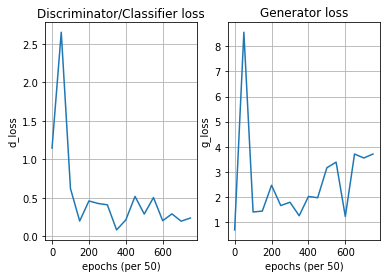

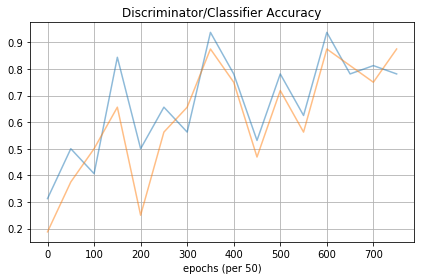

In [217]:
x = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]
d_loss = [1.1466, 2.649109, 0.620925, 0.200368, 0.460990, 0.428126, 0.410835, 0.085274, 0.214923, 0.519703, 0.291219, 0.505386, 0.204581, 0.293442, 0.198557, 0.239489]
g_loss = [0.690435, 8.559340, 1.403960, 1.439888, 2.467533, 1.660146, 1.792909, 1.253919, 2.022333, 1.971465, 3.164767, 3.387980, 1.225002, 3.711246, 3.553851, 3.710154]
d_binary_acc = [0.3125, 0.5, 0.4062, 0.8438, 0.5, 0.6562, 0.5625, 0.9375, 0.7812, 0.5312, 0.7812, 0.625, 0.9375, 0.7812, 0.8125, 0.7812]
d_classes_acc = [0.1875,0.375, 0.5, 0.6562, 0.25,0.5625, 0.6562, 0.875, 0.75, 0.4688, 0.7188, 0.5625, 0.875, 0.8125, 0.75, 0.875]
plot(800, x, d_loss, g_loss, d_binary_acc, d_classes_acc)

In [216]:
def plot(epoches, x, d_loss, g_loss, d_binary_acc, d_classes_acc):
    #plt.figure(1) # plot with various axes scales
    plt.figsize=(20,20)
    
    # d_loss
    plt.subplot(1,2, 1)
    plt.plot(x, d_loss)
    plt.ylabel('d_loss')
    plt.xlabel('epochs (per 50)')
    plt.title("Discriminator/Classifier loss")
    plt.grid(True)
    
    # g_loss
    plt.subplot(1,2, 2)
    plt.plot(x, g_loss)
    plt.ylabel('g_loss')
    plt.xlabel('epochs (per 50)')
    plt.title("Generator loss")
    plt.grid(True)
    
    plt.figure(2) # plot with various axes scales
    # Binary acc
    plt.subplot(1,1,1)
    plt.plot(x, d_binary_acc, label = 'Binary Accuracy' , alpha = 0.5)
    plt.plot(x, d_classes_acc, label = 'Classes Accuracy' , alpha = 0.5 )
    plt.xlabel('epochs (per 50)')
    plt.title("Discriminator/Classifier Accuracy")
    plt.grid(True)
    
    plt.subplots_adjust(hspace=0.5)
    
    plt.tight_layout()
    plt.show()
    

In [121]:
test_sgan = SGAN()
test_sgan.train(x_train, y_train, epochs=10, batch_size=32, save_interval=50)    

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_168 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 17

#### Epoches 800, Updated G and D

In [104]:
sgan1 = SGAN()
start = timeit.default_timer()
sgan1.train(x_train, y_train, epochs=800, batch_size=32, save_interval=50)
end = timeit.default_timer()

1.Build and compile the discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
zero_padding2d_20 (ZeroPaddi (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_134 (Bat (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 17

In [ ]:
def predict_car(image):
    my_image = scipy.misc.imresize(image, size=(64,64))
    plt.imshow(my_image)
    plt.show()

    img_array = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64, 64, 3 ))
    # Normalize
    img_array = (img_array.astype(np.float32) - 127.5) / 127.5
    #print(img_array.shape)
    
    #Suppress Scientific Notation in Numpy
    np.set_printoptions(suppress=True)  
    
    probabilities = sgan.discriminator.predict(img_array)
    
    r_f_prediction = [float(round(x)) for x in probabilities[0]][0]
    if r_f_prediction == 1.0:
        r_f_prediction_class = "real"
    else: 
        r_f_prediction_class = "fake"
    
    
    class_plus_labels = ["normal cars", "outliers", "fake"]  # N+1 labels
    classes_probabilities = probabilities[1][0].tolist()
    print(classes_probabilities)
    class_index = classes_probabilities.index(max(classes_probabilities))
    print(class_index)
    class_prediction = class_plus_labels[class_index]
    result = "This image is " +r_f_prediction_class + ".\nClass: " + class_prediction 
    print(result)
    
    #print(real_fake_prediction, c_predictions)
    print(probabilities[0],probabilities[1])

In [ ]:
# Predict

import scipy
from skimage import io
from scipy import ndimage

img_urls = ["https://tookan.s3.amazonaws.com/task_images/qVlt1487532794972-TOOKAN20022017063311.jpg",
            "https://tookan.s3.amazonaws.com/task_images/p0eg1487642868361-photoName.jpeg",
            "https://tookan.s3.amazonaws.com/task_images/OfaQ1500541656425-TOOKAN20072017035351.jpg",
           "https://tookan.s3.amazonaws.com/task_images/RvJ21493793034122-photoName.jpeg",
           "https://tookan.s3.amazonaws.com/task_images/ZJyL1496194239293-TOOKAN31052017113038.jpg",
           "https://tookan.s3.amazonaws.com/task_images/6tD91488406242311-TOOKAN02032017091033.jpg"]
#
#"https://tookan.s3.amazonaws.com/task_images/D5Ns1500028894670-TOOKAN14072017084133.jpg",
#            "https://tookan.s3.amazonaws.com/task_images/vxBj1498636362559-TOOKAN28062017055241.jpg",
#           "https://tookan.s3.amazonaws.com/task_images/mYhY1487569424559-TOOKAN20022017014352.jpg",
#           "https://tookan.s3.amazonaws.com/task_images/LWZK1487115774919-TOOKAN15022017103452.jpg",
#           "https://tookan.s3.amazonaws.com/task_images/lXiv1496124949094-TOOKAN30052017041547.jpg",
#

for url in img_urls:
    
    image = io.imread(url)
    #plt.imshow(image)
    #plt.show()
    
    #image = np.array(ndimage.imread(fname, flatten=False))
    #my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
    predict_car(image)

#### Predict Test

### Backup

In [ ]:
models = SGAN_init()
generator = models['Generator']
discrimator = models['Discriminator']
combinded = models['Combinded']
train(X_train, y_train, generator, discrimator, combinded, epochs = 500, batch_size=32, save_interval=50)

In [ ]:
# Used for back up

def train(X_train, y_train, generator, discrimator, combinded, epochs = 500, batch_size=32, save_interval=50, numClasses = 2):
    # X_train: range from -1 to 1
    # y_train: shape (-1, 1) where -1 represent the number of examples
    
    half_batch = int(batch_size/2)
    
    # Class weights:
    # To balance the difference in occurences of digit class labels. 
    # 50% of labels that the discriminator trains on are 'fake'.
    # Weight = 1 / frequency
    cw1 = {0: 1, 1: 1}
    cw2 = {i: numClasses / half_batch for i in range(numClasses)}
    cw2[numClasses] = 1 / half_batch
    
    print"Class weights"
    print(cw1)
    print(cw2)
    
    for e in range(epochs):
        #----------------
        # Train Discrimator
        #----------------
        # Select a random half batch of images： size = half_batch
        idx = np.random.randint(0, X_train.shape[0], half_batch) # 16 random integer in range (0,m).
        images = X_train[idx]  # X_train[idx,:,:,:] get 16 train examples
        
        # Generate a random half batch of images from noise
        noise = np.random.normal(0, 1, (half_batch, 100))
        generated_images = generator.predict(noise)
        
        valid = np.ones((half_batch, 1)) # all 1 vectors with shape(16,1)
        fake = np.zeros((half_batch, 1)) # all 0 vectors with shape(16,1)
        
        # Convert labels to categorical one-hot encoding： one_hot_labels
        labels = to_categorical(y_train[idx], num_classes = numClasses+1)
        fake_lables = to_categorical(np.full((half_batch, 1), number_classes), num_classes = numClasses+1)
        
        # Train the discriminator by calculating loss value of D. 
        d_loss_real = discriminator.train_on_batch(images, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(generated_images, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #----------------
        # Train Generator
        #----------------
        noise = np.random.normal(0, 1, (batch_size, 100))   # Sample noise with shape (batch_size, 100)
        validity = np.ones((batch_size, 1))                 # all 1 vectors with shape(64,1)
        
        # Train the generator by calculating the loss value of G
        g_loss = combined.train_on_batch(noise, validity, class_weight=[cw1, cw2])

        # Plot the progress
        print ("%d [Discriminator loss: %f, acc: %.2f%%, op_acc: %.2f%%] [Generator loss: %f]" % 
               (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
        
        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch, generator)

In [ ]:
def save_imgs(epoch, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 1

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("../generated_images/outsideFront_%d.png" % epoch)
    plt.close()

In [ ]:
      def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()     